# Sensitivity Homework 2

Ron Neely, Rowan Data Mining 2
Due 2018.09.27, Assigned 2019.09.19

HW  Remember Sensitivity Analysis from DM1?  Essentially we make an average vector which is the mean of each variable in the data file.  We then compute the output of the average vector with each variable ranging from 0 to 1 and see what the difference is.  (In R,  sapply(vector,mean)  might be helpful). 

1. Do a sensitivity analysis on the Neural network results from the breast cancer file and see which variables are the most important.  How do these compare with the Random Forest results?
2. Repeat for the SVM in the breast cancer file.  (Note you can steal my existing files for implementing the NN and SVM on the breast cancer files (see week 1 and 2 content)). You may want to switch back to a non-classification result (I.e. remove the as.factor( ) from the formula to determine sensitivity).  How do these compare with the results from part 1.
3. Remember to get the 10th point ask and answer a challenge problem that is at least tangentially connected with this HW.

We will use SALib to analyze sensitivity: [SALib Tutorial](https://github.com/SALib/SATut/blob/master/Using%20SA%20to%20Interrogate%20Models/Using%20Sensitivity%20Analysis.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold

# pip install SALib # https://github.com/SALib
import SALib.sample.saltelli as ss
import SALib.analyze.sobol as sa
import SALib.plotting as sp

from SALib.sample import morris as ms
import SALib.analyze.morris as ma

import sys
sys.version

'3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]'

## Read data in to a pandas DataFrame and normalize

In [2]:
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['y'] = pd.Series(sklearn_dataset.target)
    return df

df = sklearn_to_df(datasets.load_breast_cancer())
print(df.shape)
print(df.dtypes, end=' ')
df.head(3)

(569, 31)
mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symm

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0          0.11840   
1        20.57         17.77           132.9     1326.0          0.08474   
2        19.69         21.25           130.0     1203.0          0.10960   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   

   mean fractal dimension ...  worst texture  worst perimeter  worst area  \
0                 0.07871 ...          17.33            184.6      2019.0   
1                 0.05667 ...          23.41            158.8      1956.0   
2                 0.05999 ...          25.53            152.5      1709.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   

   worst symmetry  worst fractal dimension  y  
0          0.4601                  0.11890  0  
1          0.2750                  0.08902  0  
2          0.3613                  0.08758  0  

[3 rows x 31 columns]

In [3]:
y = df['y']
print(len(y))
print(y.dtype)
y.head(3)

569
int32


0    0
1    0
2    0
Name: y, dtype: int32

In [4]:
X_cols = df.columns[0:-1]
scaler = StandardScaler()
df[X_cols] = scaler.fit_transform(df[X_cols])
X = df[X_cols]
print(X.shape)
X.head(3)

(569, 30)


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0     1.097064     -2.073335        1.269934   0.984375         1.568466   
1     1.829821     -0.353632        1.685955   1.908708        -0.826962   
2     1.579888      0.456187        1.566503   1.558884         0.942210   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0          3.283515        2.652874             2.532475       2.217515   
1         -0.487072       -0.023846             0.548144       0.001392   
2          1.052926        1.363478             2.037231       0.939685   

   mean fractal dimension           ...             worst radius  \
0                2.255747           ...                 1.886690   
1               -0.868652           ...                 1.805927   
2               -0.398008           ...                 1.511870   

   worst texture  worst perimeter  worst area  worst smoothness  \
0      -1.359293         2.303601    2.001237          1.307686   
1      -0.369203         1.535126    1.890489         -0.375612   
2      -0.023974         1.347475    1.456285          0.527407   

   worst compactness  worst concavity  worst concave points  worst symmetry  \
0           2.616665         2.109526              2.296076        2.750622   
1          -0.430444        -0.146749              1.087084       -0.243890   
2           1.082932         0.854974              1.955000        1.152255   

   worst fractal dimension  
0                 1.937015  
1                 0.281190  
2                 0.201391  

[3 rows x 30 columns]

## Establish a baseline model using sklearn MLPClassifier from class and show metrics

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(426, 30) (143, 30) (426,) (143,)


Looks like default split was about 75% train, 25% test.

In [6]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Metrics for basic model

In [7]:
y_pred = mlp.predict(X_test)
print("       actual\n       +   -\npred+[[tp, fp]\ndict- [fn, tn]]")
print(confusion_matrix(y_test, y_pred), "\n")
print("\n")
print(classification_report(y_test, y_pred))

       actual
       +   -
pred+[[tp, fp]
dict- [fn, tn]]
[[58  1]
 [ 1 83]] 



             precision    recall  f1-score   support

          0       0.98      0.98      0.98        59
          1       0.99      0.99      0.99        84

avg / total       0.99      0.99      0.99       143



## 1. Do a sensitivity analysis on the Neural network results from the breast cancer file.

### 1.a. Which variables are the most important?

First let make a draftsman's  pair plot to graphically see any relationships.

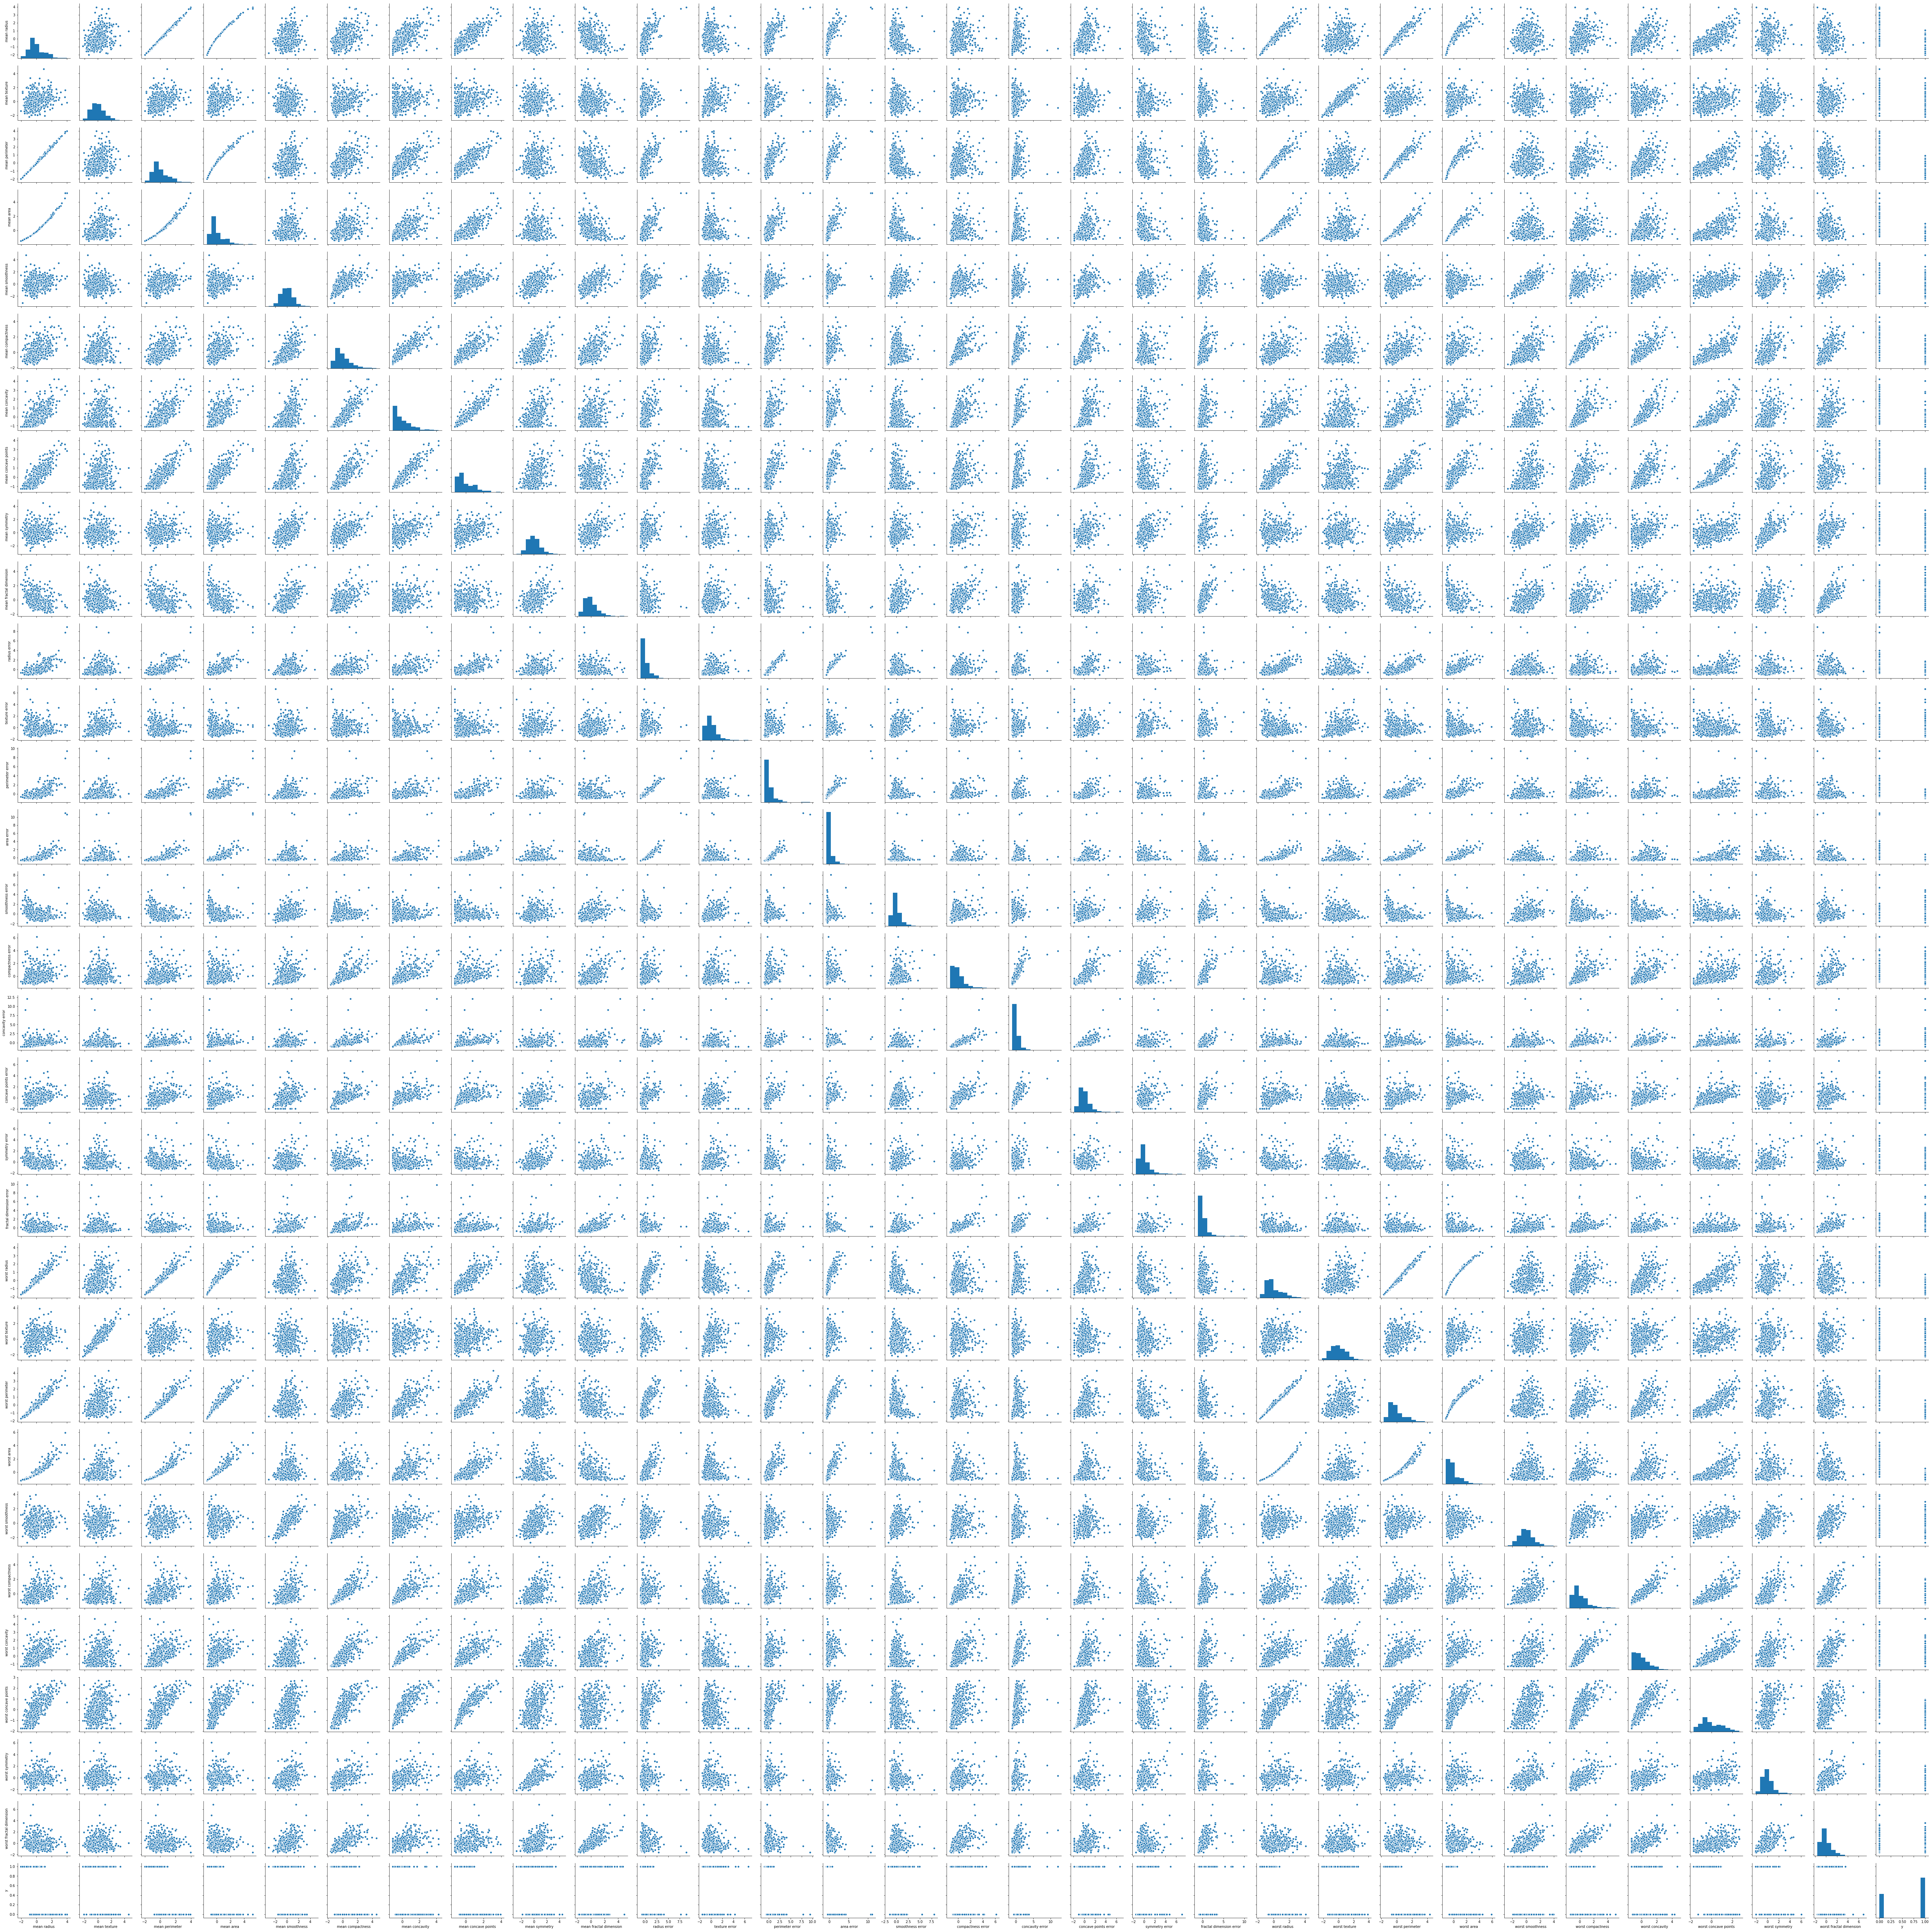

In [8]:
g = sns.pairplot(df)
g.savefig("breast_cancer_pairs.png")

Graphically looking at the last row (y) the following input factors seem to have an effect: mean_radius, mean_perimeter, mean_concave points, worst_radius, and worst_concave points.  However, it is hard to see correlation in variance as the output is binary.  There are definitely correlations between input variables and other input variables.

Let's use Sobol Sensitivity Analysis from SALib per [SALib Tutorial](https://github.com/SALib/SATut).

We are doing the sensitivity analysis on original X and y data.
This gives us a view of the problem space even before we begin building a model.

SALib is quirky.  It requires samples to be modulo 0 (number of features + 2).
We have 30 features, so following calculates the length most records we can use.

In [9]:
problem = {
    'num_vars': 30,
    'names' : list(X_cols),
    'bounds' : [ [min, max] for min, max in zip(X.min(), X.max()) ],
    'groups' : None
}

length = (30+2)*17 # 512: 30 features +2 saltelli boundary less thant 569 records
sample = ss.sample(problem, length, calc_second_order=False)
si = sa.analyze(problem, y.values[:length], calc_second_order=False)
dfs = pd.DataFrame([list(x) for x in zip(si['S1'], si['ST'], sample.mean(axis=0))],
                  columns = ["1st", "total", "mean of input"], index = problem['names'])

SALib first order Sobol results show how sensitive output is to the variablity each individual input variable.  
Features to the top of the following list have the most individual influence.

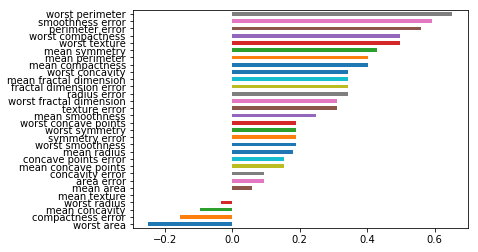

In [10]:
dfs['1st'].sort_values().plot(kind='barh')

SALib total Sobol results show how senstive output is to interactions between input variables.  
Features to the top of the following list have the most interaction effects.

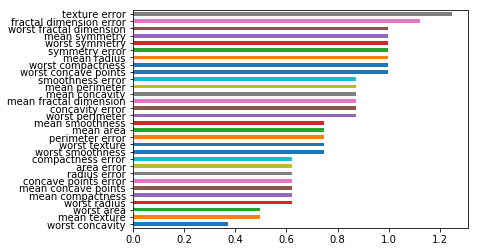

In [11]:
dfs['total'].sort_values().plot(kind='barh')

### 1.b. How do these compare with the Random Forest results?

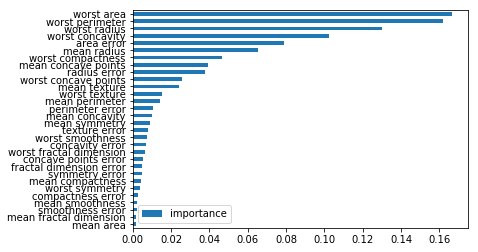

In [12]:
m = RandomForestClassifier()
m.fit(X,y)
dff = pd.DataFrame(m.feature_importances_, columns=["importance"], index=X_cols.values)
dff = dff.sort_values(by='importance', ascending=True)
dff.plot(kind='barh')

SALib Sobol and the Random Forest model both show worst_perimiter as one of the top individual fators.  There is not much more in agreement.  Random forest analysis gives a much higher precedence to mean_concave_points, whereas SALib Sobol gives it a much lower performance.  Seems like Random orest does a better job.

## 2. Repeat for the SVM in the breast cancer file.  
(Note you can steal my existing files for implementing the NN and SVM on the breast cancer files (see week 1 and 2 content)). You may want to switch back to a non-classification result (I.e. remove the as.factor( ) from the formula to determine sensitivity).  How do these compare with the results from part 1.

In [13]:
svm = SVC()
svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)
print("       actual\n       +   -\npred+[[tp, fp]\ndict- [fn, tn]]")
print(confusion_matrix(y_test, y_pred), "\n")
print("\n")
print(classification_report(y_test, y_pred))

       actual
       +   -
pred+[[tp, fp]
dict- [fn, tn]]
[[58  1]
 [ 1 83]] 



             precision    recall  f1-score   support

          0       0.98      0.98      0.98        59
          1       0.99      0.99      0.99        84

avg / total       0.99      0.99      0.99       143



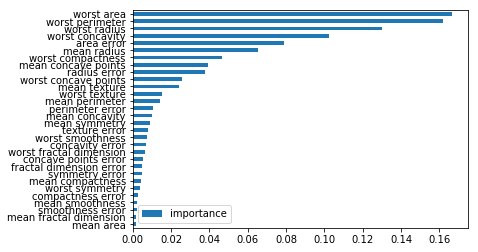

In [14]:
y_pred = svm.predict(X[:length])

problem = {
    'num_vars': 30,
    'names' : list(X_cols),
    'bounds' : [ [min, max] for min, max in zip(X[:length].min(), X[:length].max()) ],
    'groups' : None
}
sample = ss.sample(problem, length, calc_second_order=False)
si = sa.analyze(problem, y_pred, calc_second_order=False)
dfs = pd.DataFrame([list(x) for x in zip(si['S1'], si['ST'], sample.mean(axis=0))],
                  columns = ["1st", "total", "mean of input"], index = problem['names'])
dfs = dff.sort_values(by='importance', ascending=True)
dfs.plot(kind='barh')

Worst_perimeter, smoothness_error and worst_texture are still among the most important factors - though the order has changed.

## Challenge question 
    
Remember to get the 10th point ask and answer a challenge problem that is at least tangentially connected with this HW.

How would SALib morris analysis compare to Sobel and RandomForest?

In [15]:
length = int(569/(30 + 1))*31
length

558

In [16]:
sample = ms.sample(problem, length, num_levels=4, grid_jump=2)
Sj = ma.analyze(problem, sample, y.values[:length].astype(float), print_to_console=False)
ig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si, {})
mp.covariance_plot(ax2, Si, {})

ValueError: cannot reshape array of size 558 into shape (558,31)

SALib is quirky.  Morris analysis didn't work.